# Time Series Assignment 4

In [ ]:
import kagglehub
path = kagglehub.dataset_download("jeanmidev/smart-meters-in-london")
!pip install -qU prophet

100%|██████████| 1.17G/1.17G [00:30<00:00, 40.7MB/s]

Extracting files...


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

import os

## Reading The Data

In [ ]:
block = pd.read_csv(os.path.join(path, 'hhblock_dataset/hhblock_dataset/block_10.csv'),  parse_dates=['day'])
block

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000322,2012-03-07,0.125,0.104,0.133,0.145,0.109,0.298,0.149,0.119,...,0.087,0.092,0.187,0.130,0.096,0.096,0.137,0.101,0.137,0.485
1,MAC000322,2012-03-08,0.279,0.247,0.253,0.275,0.114,0.105,0.117,0.141,...,0.105,0.132,0.252,0.105,0.096,0.129,0.120,0.070,0.039,0.074
2,MAC000322,2012-03-09,0.036,0.130,0.364,0.120,0.100,0.118,0.146,0.105,...,0.028,0.030,0.072,0.038,0.029,0.046,0.069,0.029,0.050,0.520
3,MAC000322,2012-03-10,0.435,0.093,0.105,0.138,0.099,0.096,0.133,0.129,...,0.120,0.125,0.115,0.101,0.142,0.112,0.099,0.150,0.152,0.097
4,MAC000322,2012-03-11,0.187,0.122,0.094,0.109,0.139,0.099,0.111,0.137,...,0.036,0.100,0.358,0.122,0.095,0.111,0.141,0.097,0.095,0.122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31473,MAC005354,2014-02-23,0.103,0.069,0.101,0.144,0.080,0.061,0.105,0.130,...,0.078,0.098,0.124,0.130,0.116,0.110,0.112,0.130,0.086,0.126
31474,MAC005354,2014-02-24,0.100,0.109,0.088,0.121,0.086,0.084,0.101,0.103,...,0.064,0.114,0.135,0.141,0.081,0.130,0.128,0.090,0.109,0.152
31475,MAC005354,2014-02-25,0.110,0.069,0.103,0.140,0.082,0.061,0.112,0.129,...,0.084,0.076,0.134,0.150,0.104,0.080,0.124,0.122,0.122,0.095
31476,MAC005354,2014-02-26,0.130,0.102,0.086,0.102,0.105,0.096,0.062,0.115,...,0.067,0.102,0.134,0.122,0.098,0.086,0.145,0.106,0.090,0.121


In [ ]:
def convert_standard_form_to_expand_time_series(standard_df, verbose=False):
   # Similar to compact steps
  expand_df = pd.melt(standard_df, id_vars=['day','LCLid'],value_name='energy_consumption',var_name='offset')
  expand_df['offset'] = expand_df['offset'].str.replace('hh_','').astype(int)
  expand_df = expand_df.sort_values(by=['day','offset']).reset_index(drop=True)
#   expand_df['frequency'] = '30min'
#   expand_df['serie_length'] = len(expand_df)
  ## Here we resample our day column to construct a timestamp column with frequenct 30min
  expand_df['timestamp'] = pd.date_range(start=standard_df['day'].min(), freq='30min', periods=len(expand_df))
  ## Drop unnecessary columns
  expand_df = expand_df.drop(columns=['day','offset'])
#   expand_df = expand_df[['LCLid','timestamp','energy_consumption','frequency','serie_length']]
  expand_df = expand_df[['LCLid','timestamp','energy_consumption']]
  if verbose:
    display(expand_df)
  return expand_df


In [ ]:
block_id =block[block['LCLid'] == 'MAC000322']
expanded_df = convert_standard_form_to_expand_time_series(block_id)
expanded_df

,LCLid,timestamp,energy_consumption
0,MAC000322,2012-03-07 00:00:00,0.125
1,MAC000322,2012-03-07 00:30:00,0.104
2,MAC000322,2012-03-07 01:00:00,0.133
3,MAC000322,2012-03-07 01:30:00,0.145
4,MAC000322,2012-03-07 02:00:00,0.109
...,...,...,...
34507,MAC000322,2014-02-23 21:30:00,0.116
34508,MAC000322,2014-02-23 22:00:00,0.108
34509,MAC000322,2014-02-23 22:30:00,0.129
34510,MAC000322,2014-02-23 23:00:00,0.058


In [ ]:
df = expanded_df.drop('LCLid', axis=1).set_index('timestamp')
df

,energy_consumption
timestamp,
2012-03-07 00:00:00,0.125
2012-03-07 00:30:00,0.104
2012-03-07 01:00:00,0.133
2012-03-07 01:30:00,0.145
2012-03-07 02:00:00,0.109
...,...
2014-02-23 21:30:00,0.116
2014-02-23 22:00:00,0.108
2014-02-23 22:30:00,0.129


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34512 entries, 2012-03-07 00:00:00 to 2014-02-23 23:30:00
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   energy_consumption  34511 non-null  float64
dtypes: float64(1)
memory usage: 539.2 KB


In [ ]:
df.describe()

,energy_consumption
count,34511.000000
mean,0.106438
std,0.105291
min,0.009000
25%,0.053000
50%,0.083000
75%,0.124000
max,1.159000


In [ ]:
df[df['energy_consumption'].isna()]

,energy_consumption
timestamp,
2012-12-14 15:00:00,NaN


In [ ]:
df['energy_consumption'] = df['energy_consumption'].interpolate(method='spline', order=3)
df['energy_consumption'].isna().sum()

np.int64(0)

#### Setting hourly, daily, weekly, and monthly data

In [ ]:
hourly_df = df.resample('1h').sum()
daily_df = df.resample('1D').sum()
weekly_df = df.resample('1W').sum()
monthly_df = df.resample('1MS').sum()

In [ ]:
def run_seq_plot(consumption, title, x_label='Time', y_label='Consumption'):
    time = consumption.index
    plt.figure(figsize=(18,6))
    plt.plot(time, consumption)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(alpha=0.3)

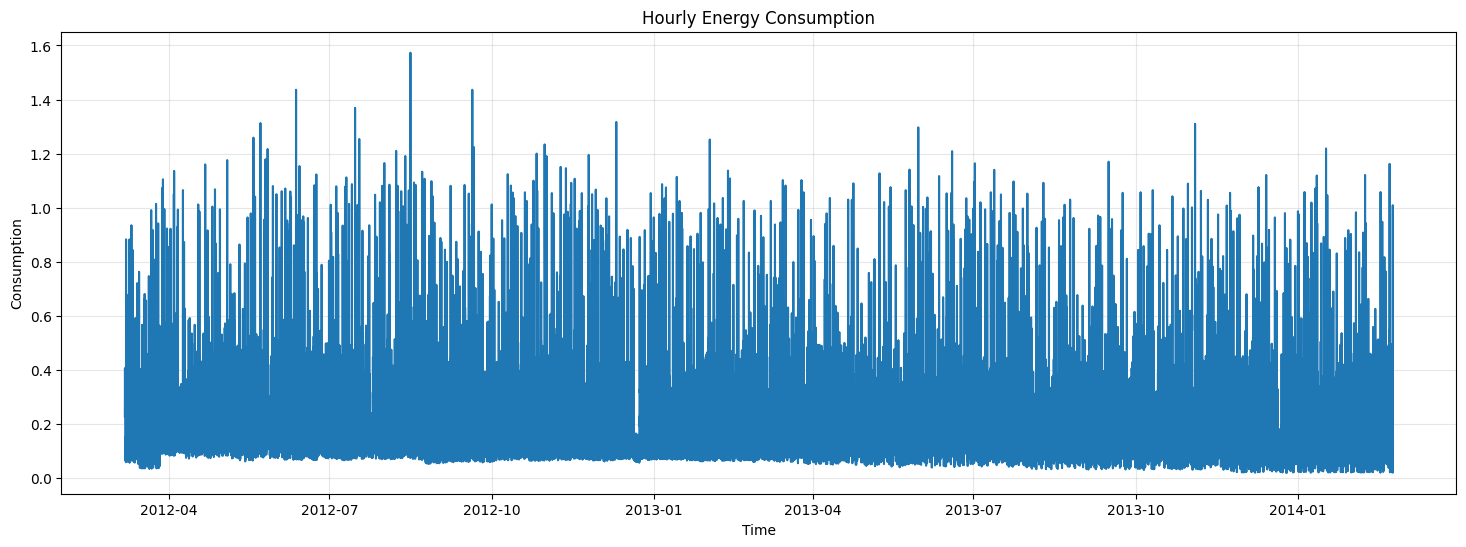

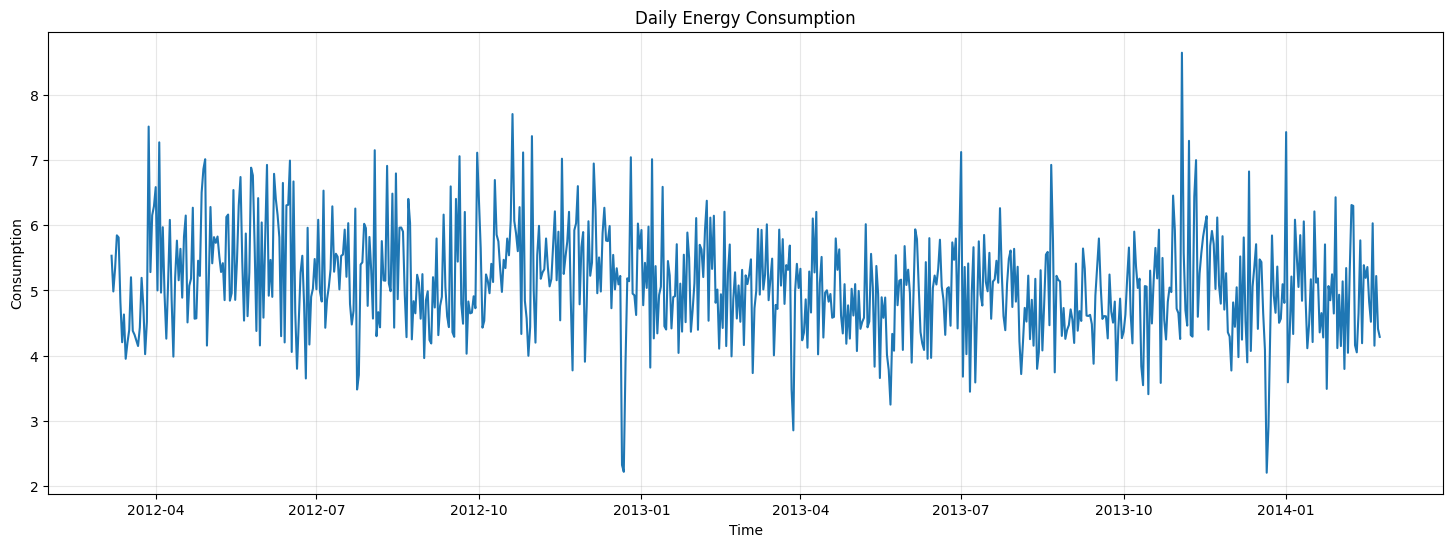

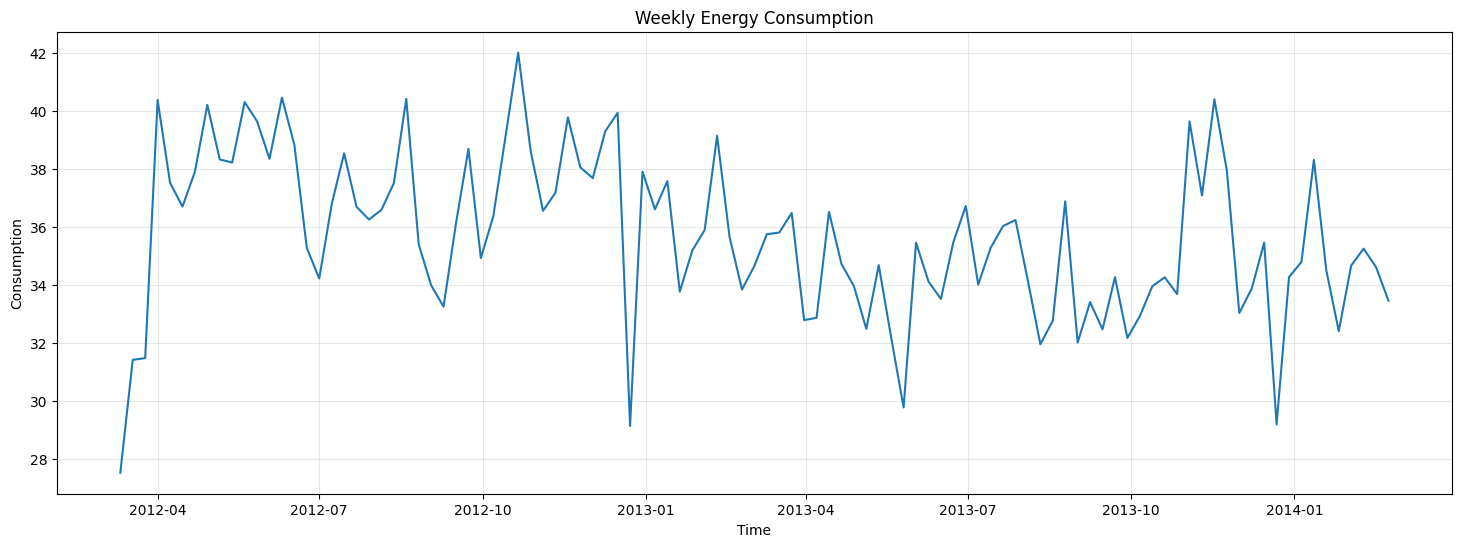

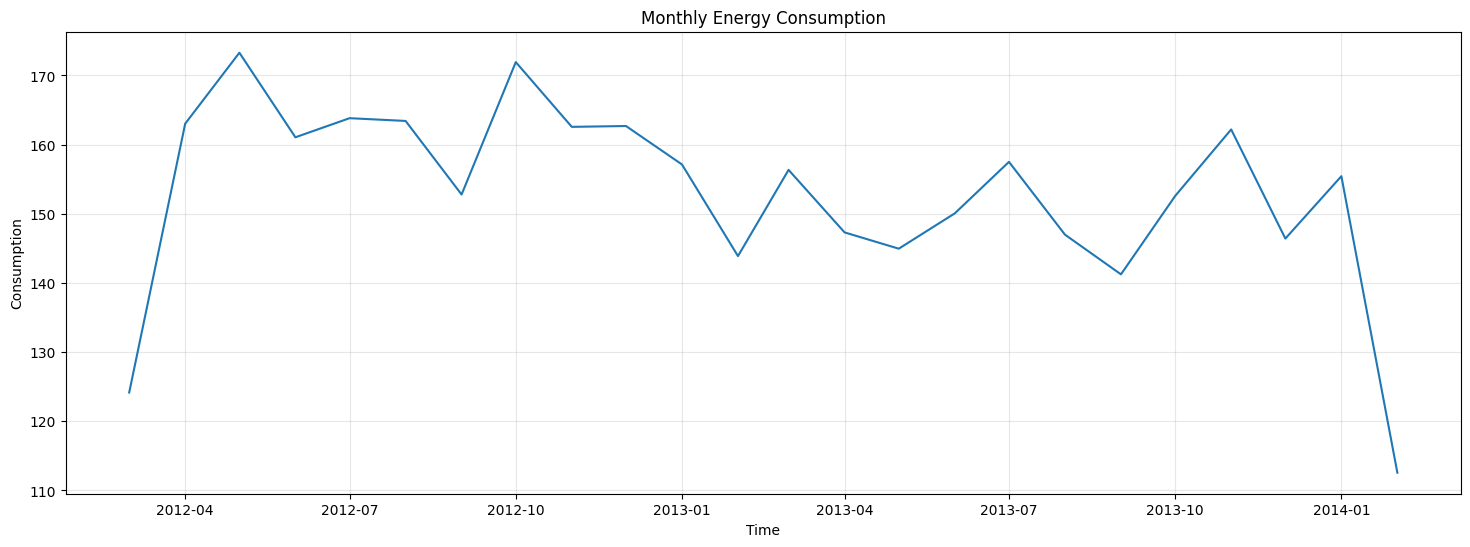

In [ ]:
run_seq_plot(hourly_df['energy_consumption'], 'Hourly Energy Consumption')
run_seq_plot(daily_df['energy_consumption'], 'Daily Energy Consumption')
run_seq_plot(weekly_df['energy_consumption'], 'Weekly Energy Consumption')
run_seq_plot(monthly_df['energy_consumption'], 'Monthly Energy Consumption')

### Preparing Data for Prophet

In [ ]:
weekly_df.head()

,energy_consumption
timestamp,
2012-03-11,27.511
2012-03-18,31.404
2012-03-25,31.464
2012-04-01,40.365
2012-04-08,37.513


In [ ]:
def prepare_for_prophet(df):
    assert isinstance(df, pd.DataFrame), 'Must pass a dataframe'
    dfcopy = df.copy()

    dfcopy = dfcopy.reset_index()
    dfcopy.columns = ['ds', 'y']

    return dfcopy

In [ ]:
p_hourly = prepare_for_prophet(hourly_df)
p_daily = prepare_for_prophet(daily_df)
p_weekly = prepare_for_prophet(weekly_df)
p_monthly = prepare_for_prophet(monthly_df)

### Hourly

Let's start by trying to fit the model toh ehourly data.

In [ ]:
m_hourly = Prophet()
m_hourly.fit(p_hourly)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphecsso2i/aiozvhkj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphecsso2i/x5l2doqv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59774', 'data', 'file=/tmp/tmphecsso2i/aiozvhkj.json', 'init=/tmp/tmphecsso2i/x5l2doqv.json', 'output', 'file=/tmp/tmphecsso2i/prophet_model8pvocbg4/prophet_model-20250422180318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
f_hourly = m_hourly.make_future_dataframe(periods=24*30, freq='h') # predicting a month
f_hourly.tail()

,ds
17971,2014-03-25 19:00:00
17972,2014-03-25 20:00:00
17973,2014-03-25 21:00:00
17974,2014-03-25 22:00:00
17975,2014-03-25 23:00:00


In [ ]:
forecast_hourly = m_hourly.predict(f_hourly)
forecast_hourly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2012-03-07 00:00:00,0.319340,0.129110,0.516211
1,2012-03-07 01:00:00,0.323039,0.134176,0.532440
2,2012-03-07 02:00:00,0.318162,0.114346,0.522963
3,2012-03-07 03:00:00,0.299069,0.098528,0.488578
4,2012-03-07 04:00:00,0.263872,0.050642,0.452154
...,...,...,...,...
17971,2014-03-25 19:00:00,0.211137,0.002334,0.424489
17972,2014-03-25 20:00:00,0.234105,0.039210,0.431299
17973,2014-03-25 21:00:00,0.260634,0.048654,0.443047
17974,2014-03-25 22:00:00,0.283023,0.080360,0.487530


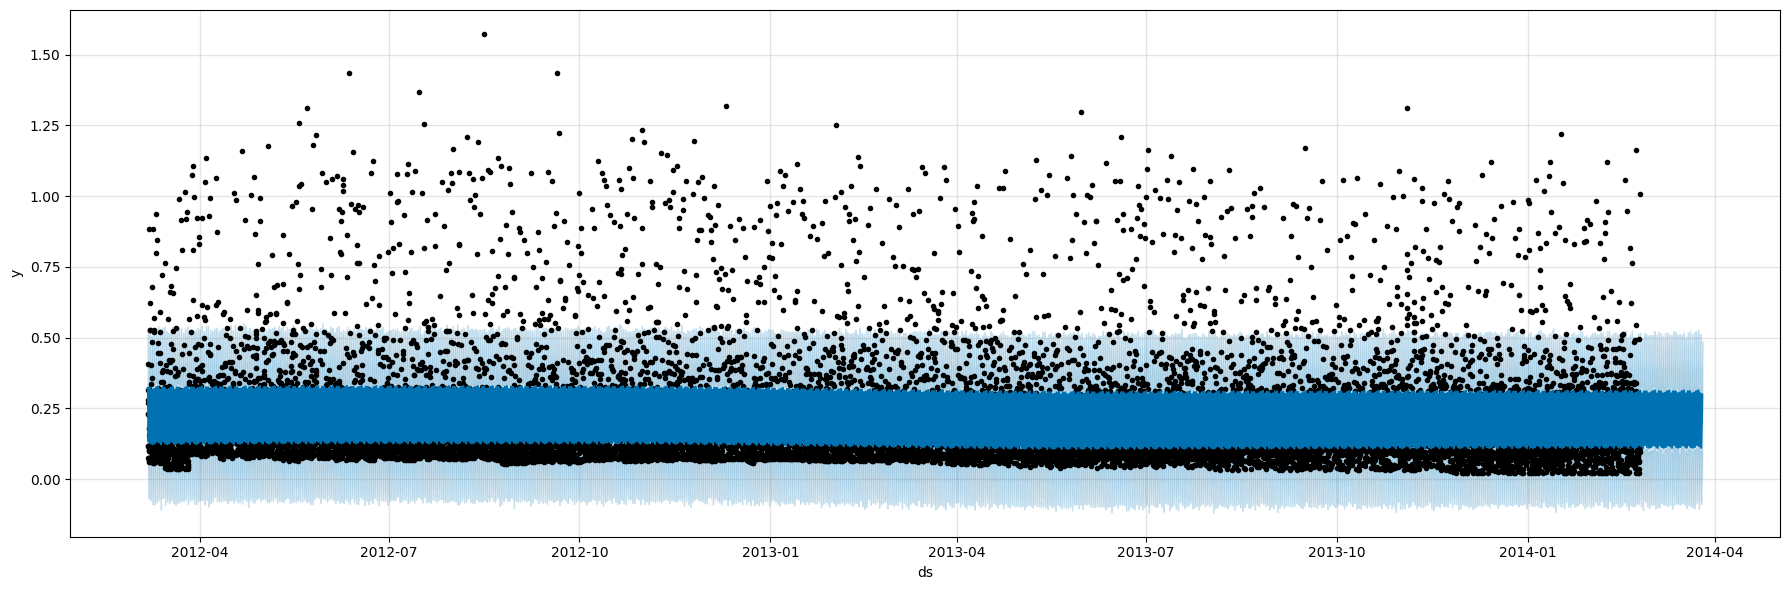

In [ ]:
m_hourly.plot(forecast_hourly, figsize=(18,6));

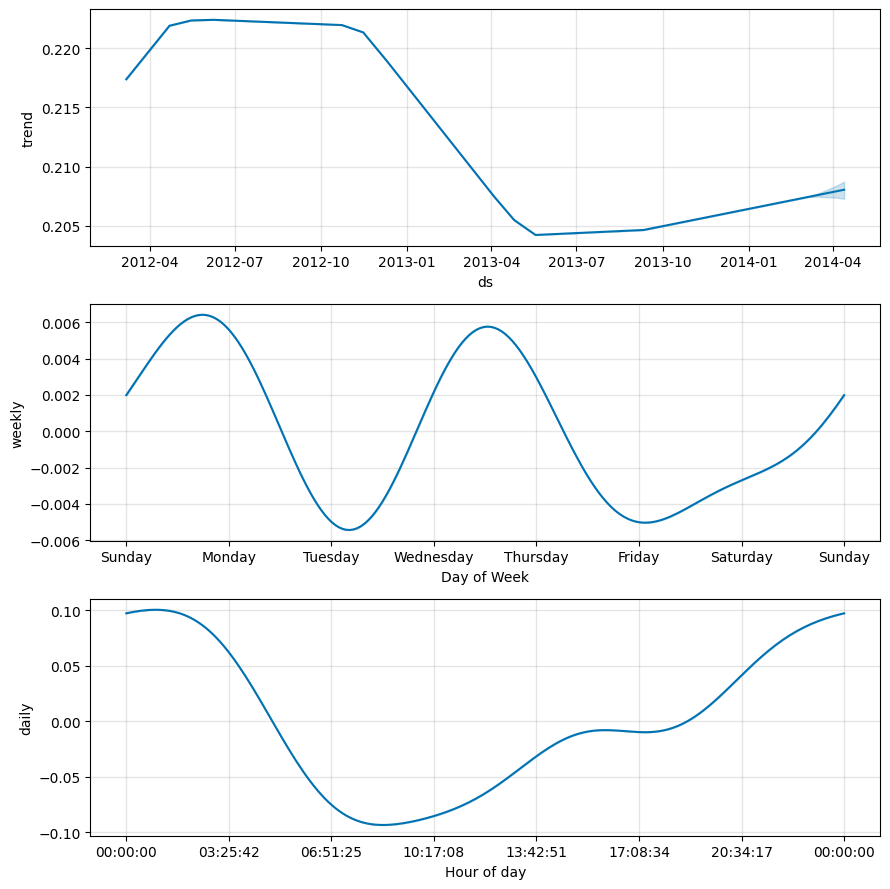

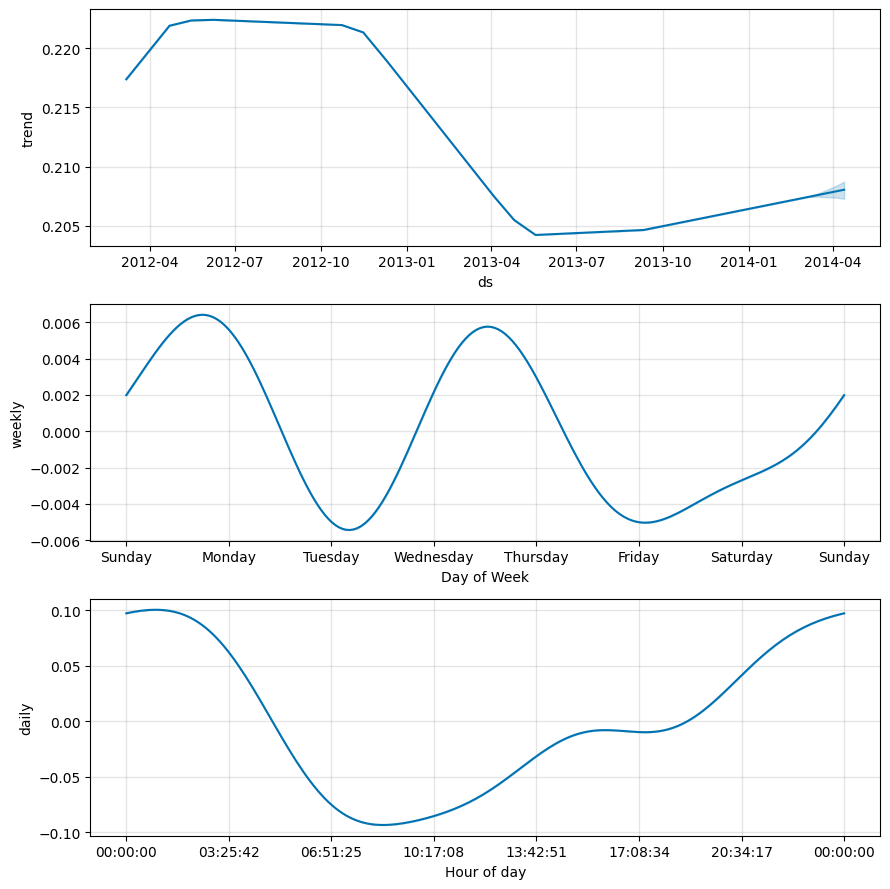

In [ ]:
m_hourly.plot_components(forecast)

To be fair, I can't really tell if it's fitting the data well or not so we need to zoom in.
so let's train a new model on only a subset of the data and see how it fits it.


DEBUG:cmdstanpy:input tempfile: /tmp/tmphecsso2i/c76383_k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphecsso2i/tnx4shnl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3753', 'data', 'file=/tmp/tmphecsso2i/c76383_k.json', 'init=/tmp/tmphecsso2i/tnx4shnl.json', 'output', 'file=/tmp/tmphecsso2i/prophet_model4mrdc8sg/prophet_model-20250422194244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:42:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:42:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


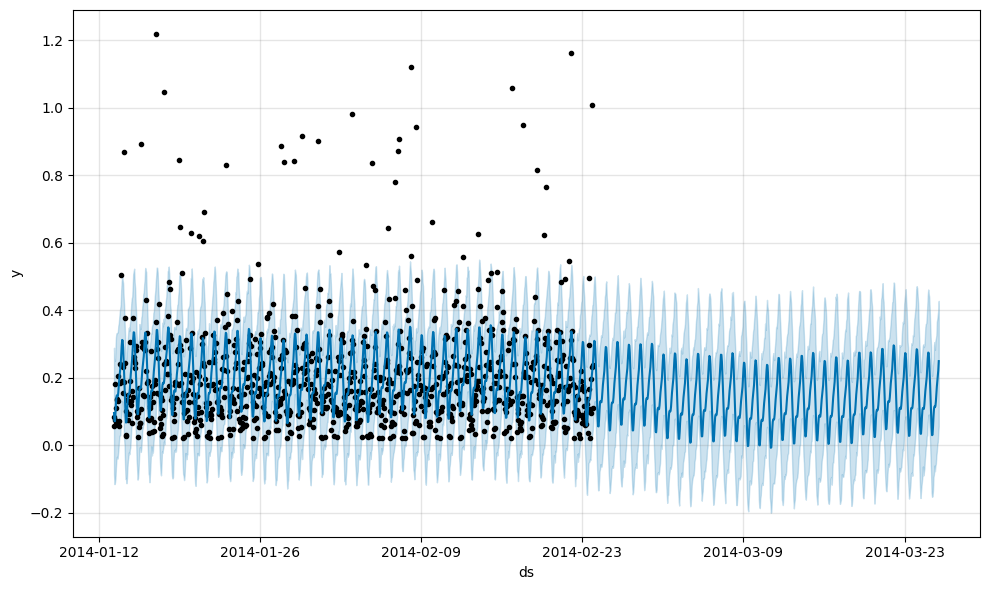

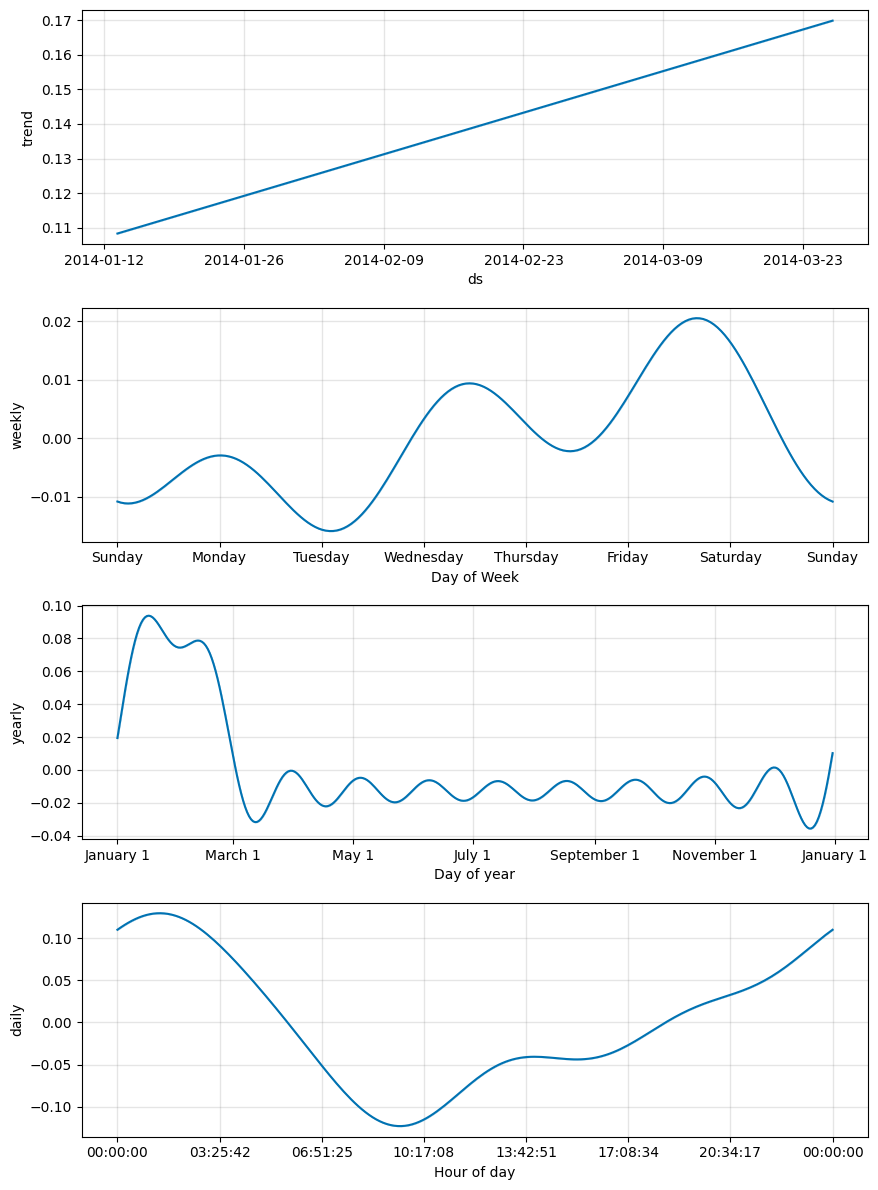

In [ ]:
m_hourly_subset = Prophet()
m_hourly_subset.fit(p_hourly[-1000:])
forecast_subset = m_hourly_subset.make_future_dataframe(periods=24*30, freq='h') # predicting a month
forecast_subset = m_hourly_subset.predict(forecast_subset)

fig = m_hourly_subset.plot(forecast_subset)

fig = m_hourly_subset.plot_components(forecast_subset)

I can see the model trying to fit the data but maybe it'ss too noisy to fit it?
Let'ss try on a more stable data like the weekly data.

### Weekly

<Axes: >

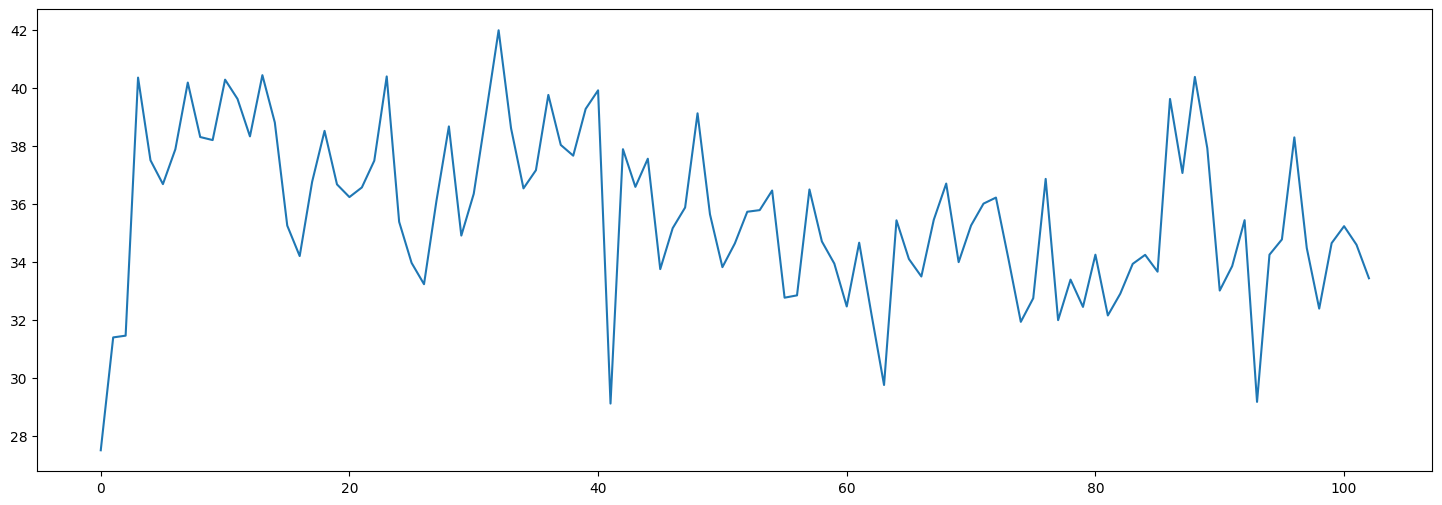

In [ ]:
p_weekly['y'].plot(figsize=(18,6))

In [ ]:
p_weekly

,ds,y
0,2012-03-11,27.511
1,2012-03-18,31.404
2,2012-03-25,31.464
3,2012-04-01,40.365
4,2012-04-08,37.513
...,...,...
98,2014-01-26,32.397
99,2014-02-02,34.656
100,2014-02-09,35.240
101,2014-02-16,34.600


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphecsso2i/2bv9jwcz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphecsso2i/8xfit1tv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75830', 'data', 'file=/tmp/tmphecsso2i/2bv9jwcz.json', 'init=/tmp/tmphecsso2i/8xfit1tv.json', 'output', 'file=/tmp/tmphecsso2i/prophet_model6t1a1tlw/prophet_model-20250422195542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:55:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


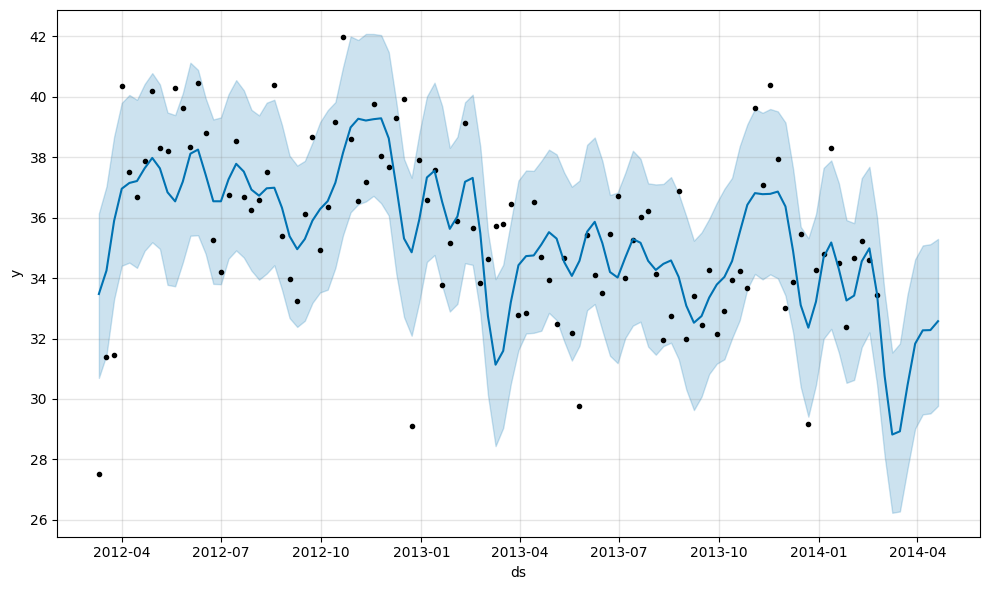

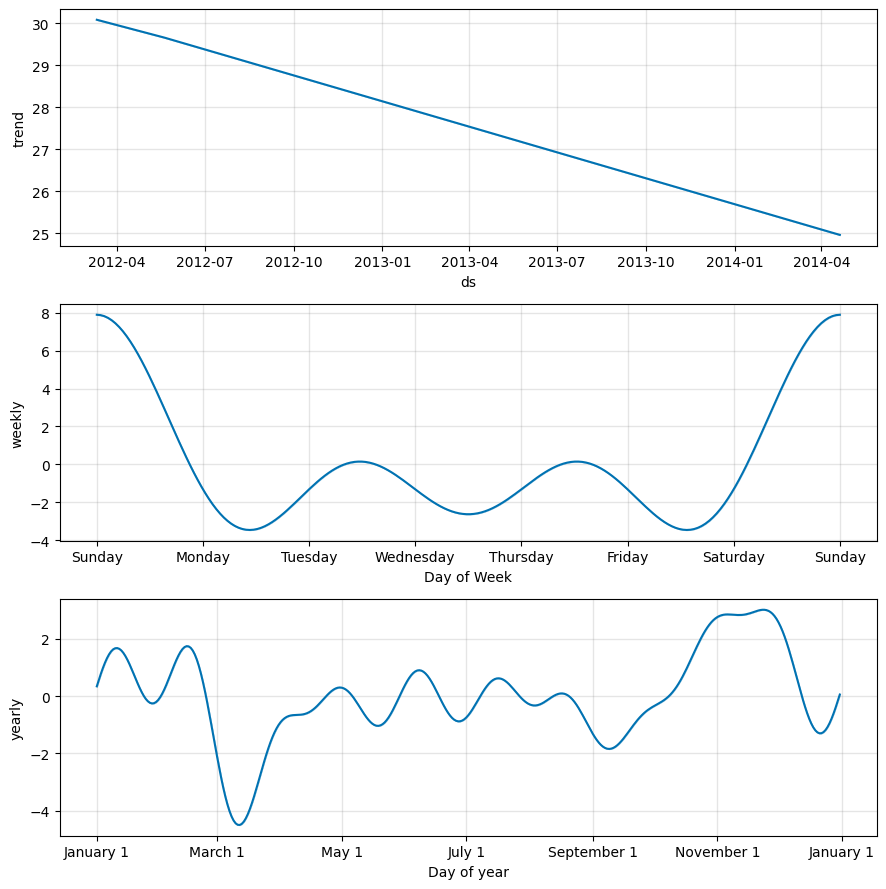

In [ ]:
m_weekly = Prophet(weekly_seasonality=True, yearly_seasonality=True)
m_weekly.fit(p_weekly)
f_weekly= m_weekly.make_future_dataframe(8, freq='W')
f_weekly = m_weekly.predict(f_weekly)
m_weekly.plot(f_weekly)
m_weekly.plot_components(f_weekly);

The model is represingt


### Daily

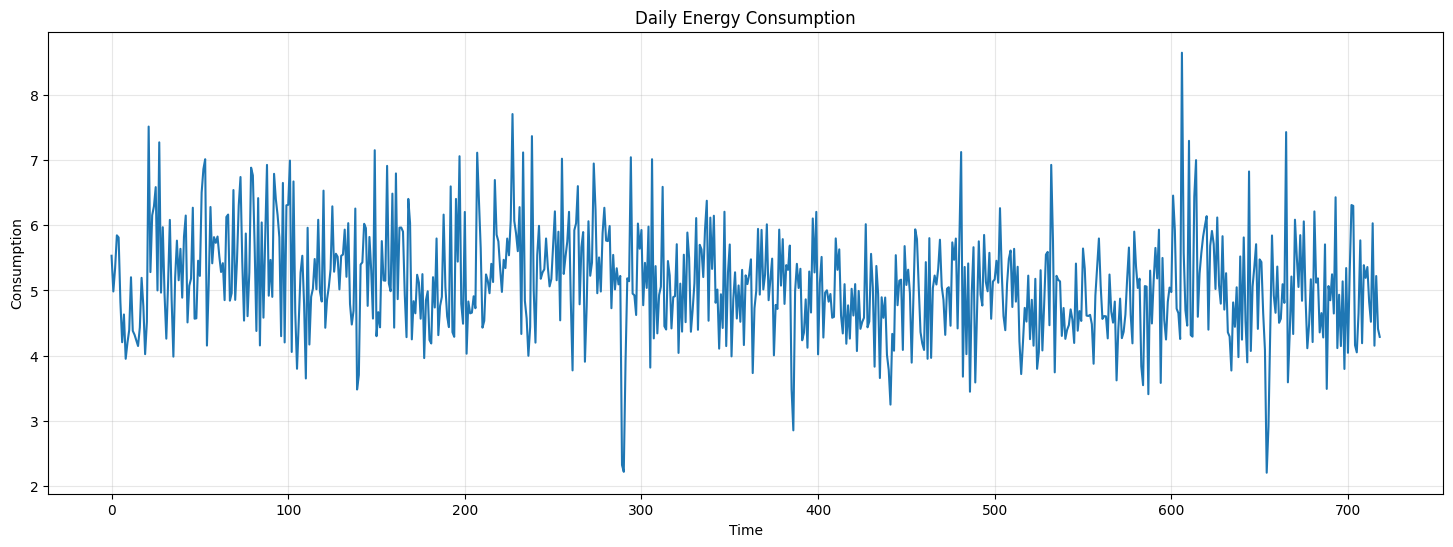

In [ ]:
run_seq_plot(p_daily['y'], 'Daily Energy Consumption')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphecsso2i/zcsovy53.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphecsso2i/xcum7o2s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53989', 'data', 'file=/tmp/tmphecsso2i/zcsovy53.json', 'init=/tmp/tmphecsso2i/xcum7o2s.json', 'output', 'file=/tmp/tmphecsso2i/prophet_model3hi34q13/prophet_model-20250422192706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:27:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:27:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


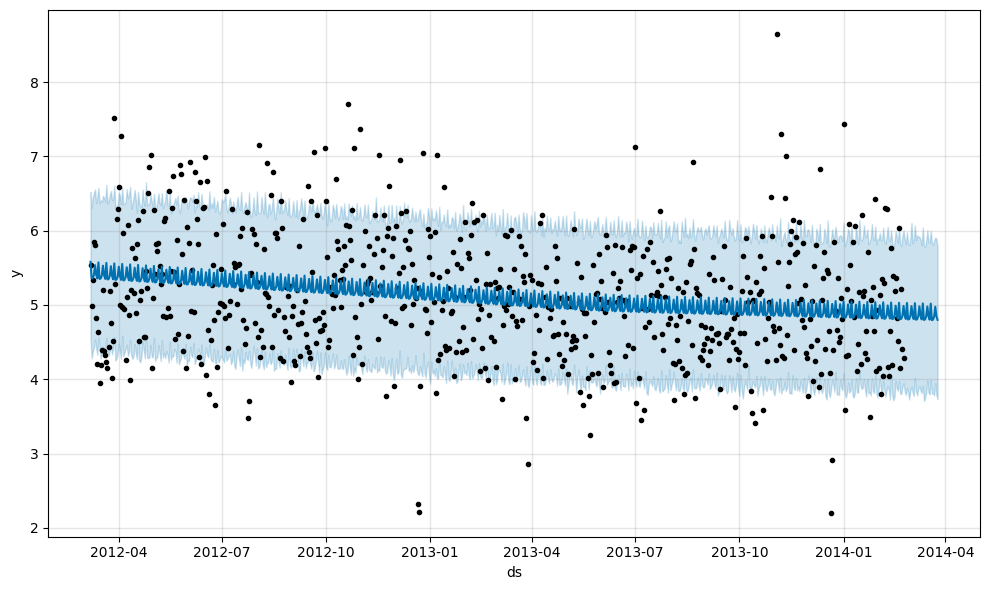

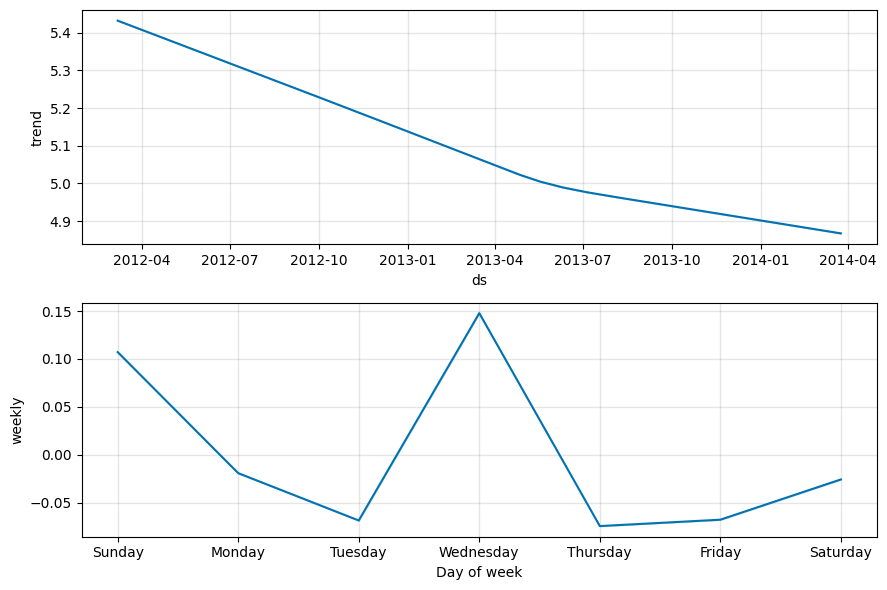

In [ ]:
m_daily = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.8)
m_daily.fit(p_daily)
f_daily = m_daily.make_future_dataframe(30, freq='D')
f_daily = m_daily.predict(f_daily)
m_daily.plot(f_daily)
m_daily.plot_components(f_daily);

In [ ]:
p_weekly.to_csv('weekly.csv')

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphecsso2i/0j84kjn6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphecsso2i/ucubq4r3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32182', 'data', 'file=/tmp/tmphecsso2i/0j84kjn6.json', 'init=/tmp/tmphecsso2i/ucubq4r3.json', 'output', 'file=/tmp/tmphecsso2i/prophet_modelhow05t0q/prophet_model-20250422210756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:07:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:07:56 - cmdstanpy - INFO - Chain [1] done proc

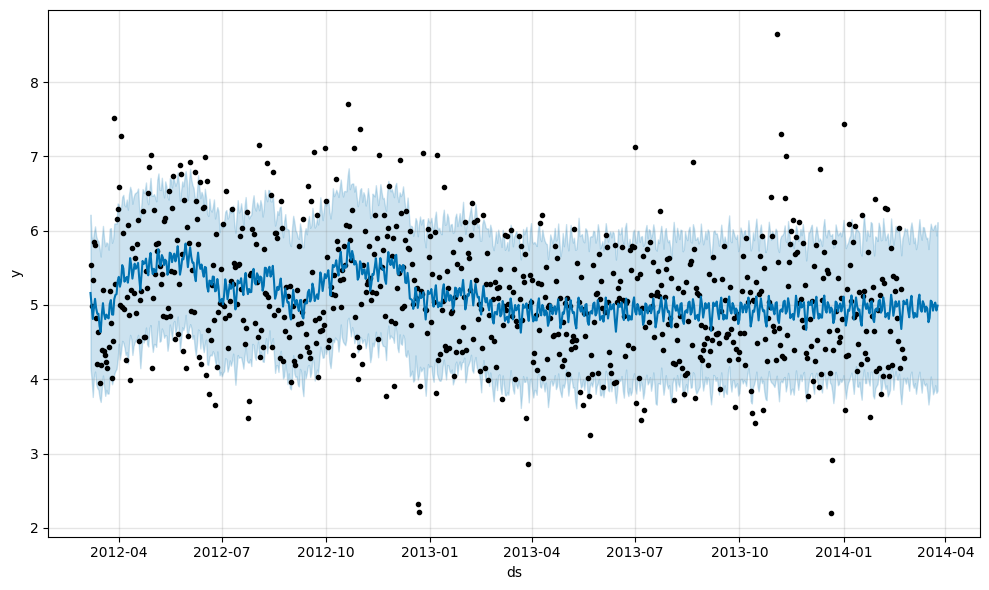

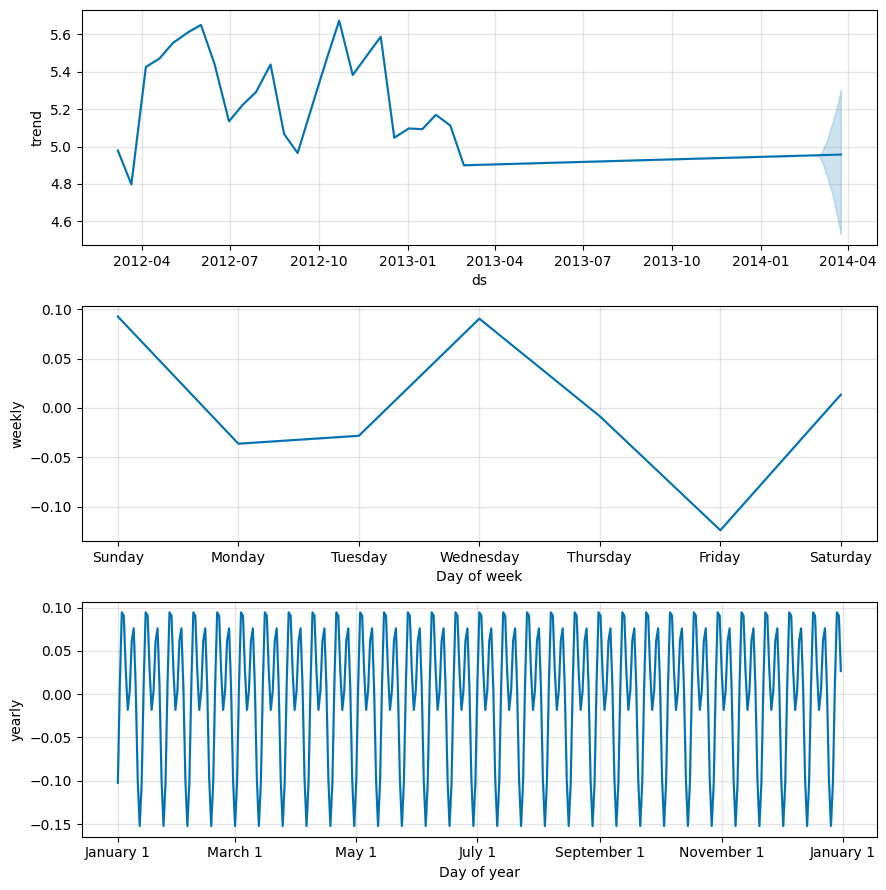